In [1]:
#import basic libraries

import numpy as np
import pandas as pd
import os
import urllib.request
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer

import boto3

import requests
import io
import gzip
import datetime

from sagemaker import KMeans
from sagemaker import get_execution_role

!pip install --upgrade pip
!pip install mxnet
import mxnet as mx

  Using cached pip-20.3.3-py2.py3-none-any.whl (1.5 MB)
  Attempting uninstall: pip
    Found existing installation: pip 20.3
    Uninstalling pip-20.3:
      Successfully uninstalled pip-20.3
     |████████████████████████████████| 55.0 MB 79 kB/s s eta 0:00:01


In [2]:
print('start time:', datetime.datetime.now())

start time: 2020-12-30 14:54:10.391744


In [3]:
#import plotting libraries

%matplotlib inline
import matplotlib.pyplot as plt  

import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')

In [4]:
bucket='cluster-demo-cloudguru'
role = get_execution_role()

In [5]:
#files already downloaded to my S3 bucket. S3 bucket stated at previous cell
#files can be found at https://datasets.imdbws.com/?opt_id=oeu1597831002244r0.9656391117513892

data_key1 = 'title.akas.tsv.gz'
data_key2 = 'title.basics.tsv.gz'
data_key3 = 'title.ratings.tsv.gz'

data_location1 = 's3://{}/{}'.format(bucket, data_key1)
data_location2 = 's3://{}/{}'.format(bucket, data_key2)
data_location3 = 's3://{}/{}'.format(bucket, data_key3)

title_akas = pd.read_csv(data_location1, compression='gzip', low_memory=False, sep='\t')
title_basics = pd.read_csv(data_location2, compression='gzip', low_memory=False, sep='\t')
title_ratings = pd.read_csv(data_location3, compression='gzip', low_memory=False, sep='\t')

### See the dimensions of the loaded datasets

In [6]:
print('title_akas dataframe shape:',title_akas.shape)
print('title_basics dataframe shape:',title_basics.shape)
print('title_ratings dataframe shape:',title_ratings.shape)

title_akas dataframe shape: (24182312, 8)
title_basics dataframe shape: (7347968, 9)
title_ratings dataframe shape: (1092100, 3)


## EDA for title basics dataset

In [7]:
title_basics.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"


In [8]:
title_basics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7347968 entries, 0 to 7347967
Data columns (total 9 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   tconst          object
 1   titleType       object
 2   primaryTitle    object
 3   originalTitle   object
 4   isAdult         int64 
 5   startYear       object
 6   endYear         object
 7   runtimeMinutes  object
 8   genres          object
dtypes: int64(1), object(8)
memory usage: 504.5+ MB


In [9]:
title_basics.nunique(axis=0) 

tconst            7347968
titleType              10
primaryTitle      3582187
originalTitle     3599844
isAdult                 8
startYear             149
endYear                95
runtimeMinutes        827
genres               2262
dtype: int64

### View how many media items are in each title type

In [10]:
title_basics.groupby('titleType')['tconst'].nunique()

titleType
movie            559134
short            778335
tvEpisode       5298964
tvMiniSeries      34279
tvMovie          111477
tvSeries         196143
tvShort           26222
tvSpecial         30301
video            286349
videoGame         26764
Name: tconst, dtype: int64

In [11]:
# drop all types except movies for our analysis and recommendations
title_basics_processed = title_basics[title_basics['titleType']=='movie']

In [12]:
title_basics_processed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 559134 entries, 8 to 7347918
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   tconst          559134 non-null  object
 1   titleType       559134 non-null  object
 2   primaryTitle    559134 non-null  object
 3   originalTitle   559134 non-null  object
 4   isAdult         559134 non-null  int64 
 5   startYear       559134 non-null  object
 6   endYear         559134 non-null  object
 7   runtimeMinutes  559134 non-null  object
 8   genres          559134 non-null  object
dtypes: int64(1), object(8)
memory usage: 42.7+ MB


In [13]:
# drop features (columns) that are irrelevant to movie categorizations / recommendations 
# endYear is a feature for TV series as described by IMDB
# titleType was narrowed down to movies so holds no information
# will not include adult films in the analysis

title_basics_processed = title_basics_processed[title_basics_processed.isAdult == 0]
title_basics_processed.drop("isAdult", axis = 1, inplace = True)

title_basics_processed.drop("titleType", axis = 1, inplace = True)
title_basics_processed.drop("endYear", axis = 1, inplace = True)

In [14]:
title_basics_processed['startYear'].unique()

array(['1894', '1900', '1905', '1906', '1907', '1908', '1909', '1910',
       '1912', '1911', '1913', '1915', '1914', '1919', '1916', '1917',
       '1936', '1925', '1918', '1920', '1922', '1921', '1924', '1923',
       '1928', '1926', '1927', '1929', '2000', '1993', '1935', '2014',
       '1930', '1942', '1932', '1931', '1934', '1939', '1937', '1933',
       '1950', '1938', '1951', '1946', '1940', '1944', '1947', '1941',
       '1952', '1970', '1957', '1943', '1945', '1948', '2001', '1949',
       '1953', '1954', '1965', '1983', '1980', '1973', '1961', '1955',
       '1962', '1958', '1956', '1964', '1967', '1960', '1959', '1968',
       '1963', '1971', '1969', '1972', '1966', '1976', '1990', '1979',
       '1981', '2020', '1975', '1978', '1989', '1974', '1977', '1986',
       '1985', '1987', '2018', '1984', '\\N', '2017', '1988', '1982',
       '1991', '1994', '2011', '1992', '1995', '2008', '2005', '1998',
       '1999', '2002', '2004', '1996', '1997', '2006', '2019', '2003',
       

In [15]:
# drop the non year string entry  '\\N' 
title_basics_processed = title_basics_processed[title_basics_processed.startYear != '\\N']

In [16]:
# convert the startYear from object (string) to interger
title_basics_processed['startYear'] = title_basics_processed['startYear'].astype(int)

In [17]:
# drop release dates above year 2020
title_basics_processed = title_basics_processed[title_basics_processed.startYear <=2020]

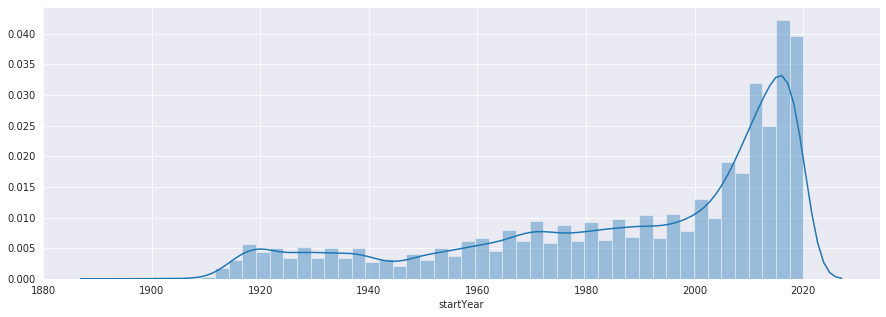

In [18]:
# visualize the startYear feature through a histogram plot
plt.figure(figsize=(15,5))
sns.distplot(title_basics_processed.startYear)

In [19]:
#drop the non run time (minutes) entry '\\N' 
title_basics_processed = title_basics_processed[title_basics_processed.runtimeMinutes != '\\N']

In [20]:
title_basics_processed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 340797 entries, 8 to 7347918
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   tconst          340797 non-null  object
 1   primaryTitle    340797 non-null  object
 2   originalTitle   340797 non-null  object
 3   startYear       340797 non-null  int64 
 4   runtimeMinutes  340797 non-null  object
 5   genres          340797 non-null  object
dtypes: int64(1), object(5)
memory usage: 18.2+ MB


In [21]:
#convert the runtimeMinutes from object (string) to interger
title_basics_processed['runtimeMinutes'] = title_basics_processed['runtimeMinutes'].astype(int)

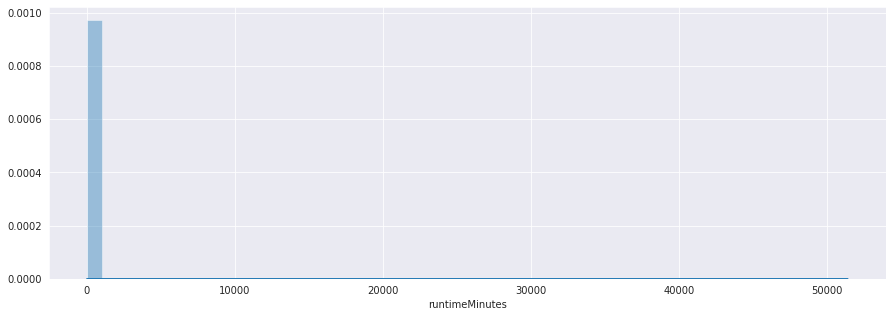

In [22]:
# visualize the startYear feature through a histogram plot
plt.figure(figsize=(15,5))
sns.distplot(title_basics_processed.runtimeMinutes)

In [23]:
# drop all movies with minute duration above 10 hours
title_basics_processed = title_basics_processed[title_basics_processed.runtimeMinutes <=600]

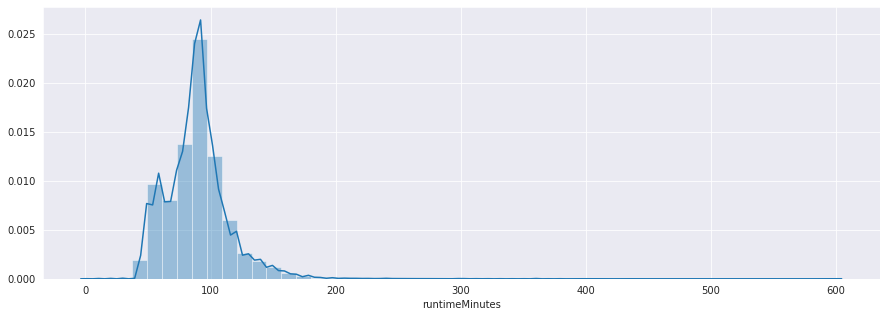

In [24]:
# visualize the startYear feature through a histogram plot 
plt.figure(figsize=(15,5))
sns.distplot(title_basics_processed.runtimeMinutes)

In [25]:
# due to the fact that each movie has up to three genres in the genres feature, we must process it for the 
# subsequent one-hot-encoding for the categorical feature 
title_basics_processed.nunique(axis=0) 

tconst            340721
primaryTitle      306567
originalTitle     314332
startYear            122
runtimeMinutes       403
genres              1266
dtype: int64

In [26]:
title_basics_processed['genres'].head(30)

8                       Romance
498                          \N
570       Biography,Crime,Drama
672           Adventure,Fantasy
1172            Adventure,Drama
1246                      Drama
1273     Biography,Drama,Family
1485                        War
1578                         \N
1616                         \N
1739                         \N
1773                      Drama
1794                      Drama
1872                      Drama
1891    Biography,Drama,History
1941                      Drama
2002              Drama,Romance
2069                         \N
2076              Drama,History
2105    Adventure,Drama,Fantasy
2128                      Drama
2161                      Drama
2174            Biography,Drama
2255                    Western
2289                         \N
2396    Biography,Drama,Romance
2398                Documentary
2405                         \N
2418              Drama,History
2425                History,War
Name: genres, dtype: object

In [27]:
# remove rows with with no genre categories (have '\N' characters)
title_basics_processed = title_basics_processed.replace(r'\\N','', regex=True) 
title_basics_processed = title_basics_processed[title_basics_processed.genres != '']

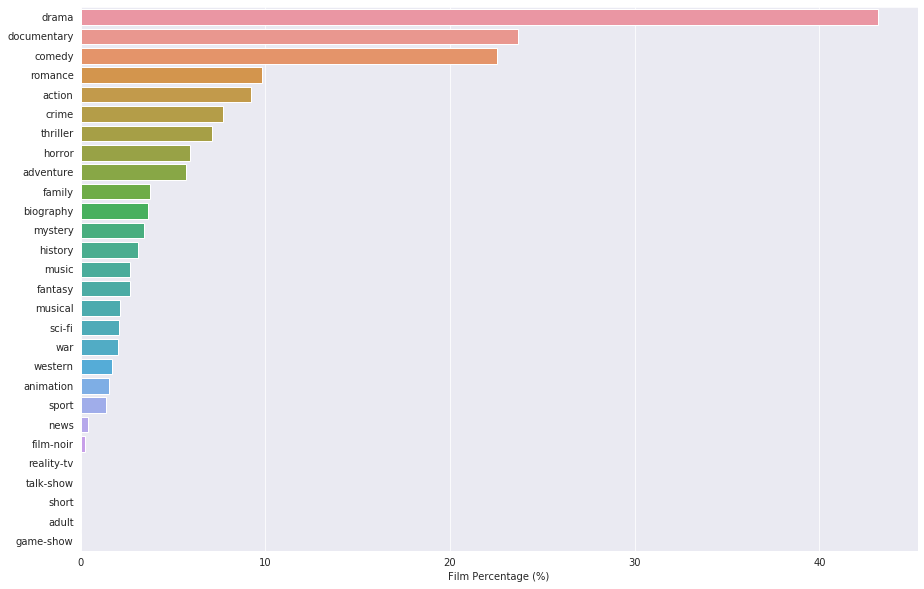

In [28]:
# visualize % of films per genre

tmp = title_basics_processed.genres.dropna()
vector = CountVectorizer(token_pattern='(?u)\\b[\\w-]+\\b', analyzer='word').fit(tmp)
descrete_genres = vector.transform(tmp)
genre_categories =  vector.get_feature_names()
np.array(genre_categories)

genres = pd.DataFrame(descrete_genres.todense(),columns=genre_categories,index=tmp.index)
genre_list = 100*pd.Series(genres.sum()).sort_values(ascending=False)/genres.shape[0]
plt.figure(figsize=(15,10))
sns.barplot(x=genre_list.values,y=genre_list.index,orient="h")
plt.xlabel("Film Percentage (%)")
plt.show()

In [29]:
### transform genre CSV type feature to one-hot-encoding like columns for ML usage

genre_split = list(title_basics_processed.genres)
genre_split = ','.join(genre_split)
genre_split = genre_split.split(',')
genre_split = list(set(genre_split))
for k in genre_split:
    title_basics_processed[k] = 0
    
for k in title_basics_processed.index:
    x = title_basics_processed['genres'][k].split(',')
    for j in x:
        title_basics_processed[j][k] = 1

In [30]:
title_basics_processed.describe()

,startYear,runtimeMinutes,Mystery,Biography,Reality-TV,Western,Documentary,Sci-Fi,Horror,Crime,...,Sport,Comedy,War,Drama,Adult,Animation,Game-Show,Action,Musical,Film-Noir
count,317924.000000,317924.000000,317924.000000,317924.000000,317924.000000,317924.000000,317924.000000,317924.000000,317924.000000,317924.00000,...,317924.000000,317924.000000,317924.000000,317924.000000,317924.000000,317924.000000,317924.000000,317924.000000,317924.000000,317924.000000
mean,1993.728916,89.745379,0.034351,0.036515,0.000497,0.016762,0.236742,0.020955,0.059344,0.07732,...,0.013761,0.225271,0.020499,0.431531,0.000088,0.015582,0.000009,0.092302,0.021609,0.002472
std,26.292227,26.038363,0.182129,0.187568,0.022287,0.128378,0.425083,0.143233,0.236268,0.26710,...,0.116498,0.417761,0.141699,0.495291,0.009384,0.123853,0.003072,0.289452,0.145403,0.049661
min,1894.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1978.000000,75.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2005.000000,90.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2014.000000,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2020.000000,600.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [31]:
title_basics_processed.columns

Index(['tconst', 'primaryTitle', 'originalTitle', 'startYear',
       'runtimeMinutes', 'genres', 'Mystery', 'Biography', 'Reality-TV',
       'Western', 'Documentary', 'Sci-Fi', 'Horror', 'Crime', 'News', 'Short',
       'Thriller', 'Music', 'Romance', 'Fantasy', 'History', 'Adventure',
       'Family', 'Talk-Show', 'Sport', 'Comedy', 'War', 'Drama', 'Adult',
       'Animation', 'Game-Show', 'Action', 'Musical', 'Film-Noir'],
      dtype='object')

In [32]:
#drop csv type genre feature 
title_basics_processed.drop("genres", axis = 1, inplace = True)

In [33]:
title_basics_processed.head()

,tconst,primaryTitle,originalTitle,startYear,runtimeMinutes,Mystery,Biography,Reality-TV,Western,Documentary,...,Sport,Comedy,War,Drama,Adult,Animation,Game-Show,Action,Musical,Film-Noir
8,tt0000009,Miss Jerry,Miss Jerry,1894,45,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
570,tt0000574,The Story of the Kelly Gang,The Story of the Kelly Gang,1906,70,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
672,tt0000679,The Fairylogue and Radio-Plays,The Fairylogue and Radio-Plays,1908,120,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1172,tt0001184,Don Juan de Serrallonga,Don Juan de Serrallonga,1910,58,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1246,tt0001258,The White Slave Trade,Den hvide slavehandel,1910,45,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [34]:
title_basics_processed.shape

(317924, 33)

# EDA of title ratings dataset

In [35]:
title_ratings.shape

(1092100, 3)

In [36]:
title_ratings.head()

,tconst,averageRating,numVotes
0,tt0000001,5.6,1662
1,tt0000002,6.1,204
2,tt0000003,6.5,1376
3,tt0000004,6.2,123
4,tt0000005,6.2,2164


In [37]:
title_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1092100 entries, 0 to 1092099
Data columns (total 3 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   tconst         1092100 non-null  object 
 1   averageRating  1092100 non-null  float64
 2   numVotes       1092100 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 25.0+ MB


In [38]:
title_ratings.describe()

,averageRating,numVotes
count,1.092100e+06,1.092100e+06
mean,6.887381e+00,9.561688e+02
std,1.398633e+00,1.595934e+04
min,1.000000e+00,5.000000e+00
25%,6.100000e+00,9.000000e+00
50%,7.100000e+00,2.000000e+01
75%,7.900000e+00,7.800000e+01
max,1.000000e+01,2.306483e+06


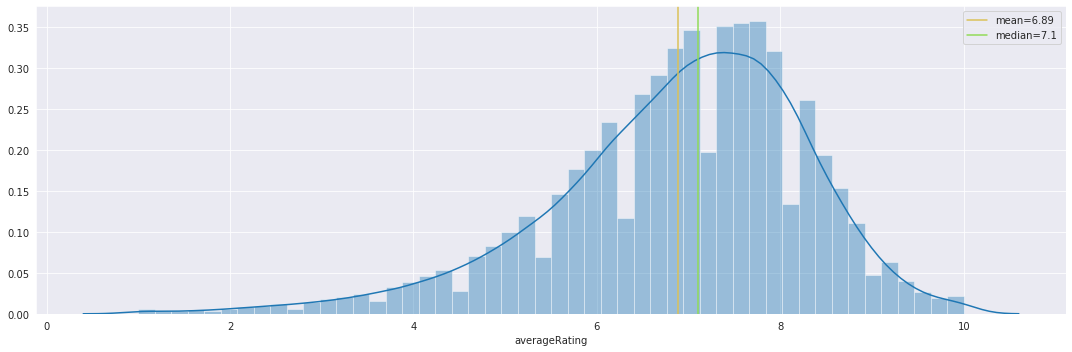

In [39]:
#visualize the distribution of averageRating
AVGratings = dict(mean=title_ratings.averageRating.mean(), median=title_ratings.averageRating.median())

plt.figure(figsize=(15,5))

ax1 = sns.distplot(title_ratings.averageRating,kde_kws=dict(bw=0.2))
ax1.axvline(x=AVGratings["mean"], c=sns.color_palette("hls", 8)[1], label=f"mean={round(AVGratings['mean'], 2)}")
ax1.axvline(x=AVGratings["median"], c=sns.color_palette("hls", 8)[2],label=f"median={round(AVGratings['median'],2)}")
plt.legend()
plt.tight_layout()
plt.show()

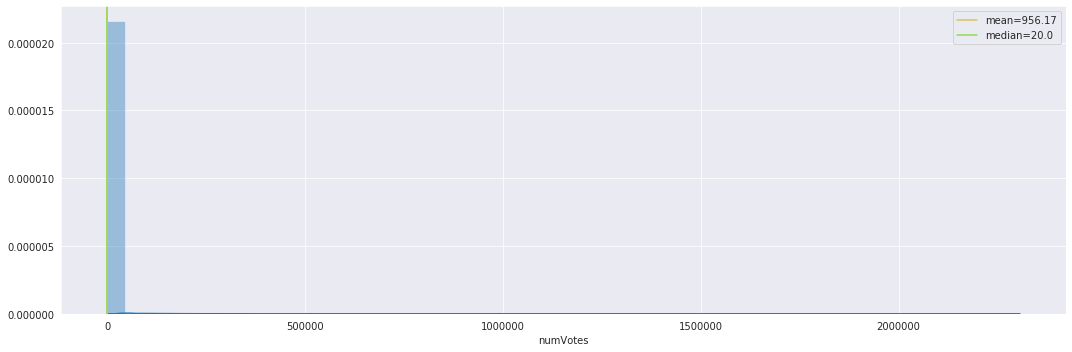

In [40]:
#visualize the distribution of numVotes

NUMvotes = dict(mean=title_ratings.numVotes.mean(), median=title_ratings.numVotes.median())

plt.figure(figsize=(15,5))

ax1 = sns.distplot(title_ratings.numVotes,kde_kws=dict(bw=0.2))
ax1.axvline(x=NUMvotes["mean"], c=sns.color_palette("hls", 8)[1], label=f"mean={round(NUMvotes['mean'], 2)}")
ax1.axvline(x=NUMvotes["median"], c=sns.color_palette("hls", 8)[2],label=f"median={round(NUMvotes['median'],2)}")
plt.legend()
plt.tight_layout()
plt.show()

### due to large number of voters with small numbers of votes, it is better to visualize with a log scale

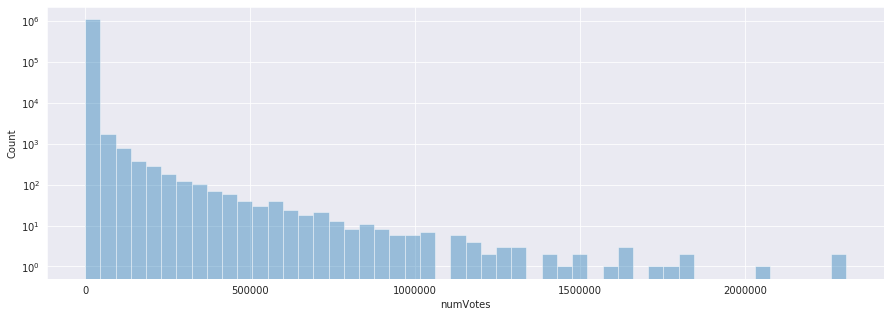

In [41]:
plt.figure(figsize=(15,5))
ax=sns.distplot(title_ratings.numVotes,kde=False)
ax.set_ylabel("Count")
ax.set_yscale("log")

### will keep for analysis movies with rating above 5 and more than 500 votes

In [42]:
title_ratings = title_ratings[(title_ratings['averageRating'] >= 5.0) & (title_ratings['numVotes'] >= 500)]

In [43]:
title_ratings.shape

(84639, 3)

# Join basic title and ratings datasets for final dataset and ML training

In [44]:
# join processed title basics dataframe with title ratings dataframe on tconst (movie ID)

final = pd.merge(left=title_basics_processed, right=title_ratings, on='tconst')

In [45]:
#inner join has removed the movies that don't have ratings 
final.shape

(39924, 35)

In [46]:
final.head(50)

,tconst,primaryTitle,originalTitle,startYear,runtimeMinutes,Mystery,Biography,Reality-TV,Western,Documentary,...,War,Drama,Adult,Animation,Game-Show,Action,Musical,Film-Noir,averageRating,numVotes
0,tt0000574,The Story of the Kelly Gang,The Story of the Kelly Gang,1906,70,0,1,0,0,0,...,0,1,0,0,0,0,0,0,6.1,598
1,tt0002130,Dante's Inferno,L'Inferno,1911,71,0,0,0,0,0,...,0,1,0,0,0,0,0,0,7.1,2293
2,tt0002423,Passion,Madame DuBarry,1919,85,0,1,0,0,0,...,0,1,0,0,0,0,0,0,6.8,762
3,tt0002844,Fantômas: In the Shadow of the Guillotine,Fantômas - À l'ombre de la guillotine,1913,54,0,0,0,0,0,...,0,1,0,0,0,0,0,0,7.0,1963
4,tt0003014,Ingeborg Holm,Ingeborg Holm,1913,96,0,0,0,0,0,...,0,1,0,0,0,0,0,0,7.1,965
5,tt0003037,Fantomas: The Man in Black,Juve contre Fantômas,1913,61,0,0,0,0,0,...,0,1,0,0,0,0,0,0,7.0,1365
6,tt0003165,Fantômas: The Dead Man Who Killed,Le mort qui tue,1913,90,1,0,0,0,0,...,0,1,0,0,0,0,0,0,7.0,1063
7,tt0003419,The Student of Prague,Der Student von Prag,1913,85,0,0,0,0,0,...,0,1,0,0,0,0,0,0,6.5,1799
8,tt0003471,Traffic in Souls,Traffic in Souls,1913,88,0,0,0,0,0,...,0,1,0,0,0,0,0,0,6.0,559
9,tt0003643,The Avenging Conscience: or 'Thou Shalt Not Kill',The Avenging Conscience: or 'Thou Shalt Not Kill',1914,78,0,0,0,0,0,...,0,1,0,0,0,0,0,0,6.4,1126


In [47]:
final.describe()

,startYear,runtimeMinutes,Mystery,Biography,Reality-TV,Western,Documentary,Sci-Fi,Horror,Crime,...,War,Drama,Adult,Animation,Game-Show,Action,Musical,Film-Noir,averageRating,numVotes
count,39924.000000,39924.000000,39924.000000,39924.000000,39924.0,39924.000000,39924.000000,39924.000000,39924.000000,39924.000000,...,39924.000000,39924.000000,39924.0,39924.000000,39924.0,39924.000000,39924.000000,39924.000000,39924.000000,3.992400e+04
mean,1995.011547,104.554554,0.069056,0.054153,0.0,0.017258,0.063020,0.037822,0.085938,0.155245,...,0.030283,0.574842,0.0,0.030959,0.0,0.154468,0.021566,0.010971,6.588493,2.016311e+04
std,23.390509,22.844094,0.253553,0.226322,0.0,0.130232,0.243002,0.190768,0.280276,0.362143,...,0.171366,0.494373,0.0,0.173208,0.0,0.361402,0.145263,0.104167,0.807227,7.803879e+04
min,1906.000000,25.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,5.000000,5.000000e+02
25%,1982.000000,91.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,6.000000,9.150000e+02
50%,2004.000000,100.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,6.600000,2.023500e+03
75%,2013.000000,113.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,7.200000,7.301750e+03
max,2020.000000,566.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,0.0,1.000000,0.0,1.000000,1.000000,1.000000,10.000000,2.306483e+06


In [48]:
# drop genres that don't have movies in the final dataset
final=final.drop(['Talk-Show','Adult','Game-Show','Reality-TV'], axis = 1)

In [49]:
#store movie info to recommend after clustering
movie_data = final[['tconst','primaryTitle','originalTitle']].copy()

In [50]:
final=final.drop(['tconst','primaryTitle','originalTitle'], axis = 1)

In [51]:
final.shape

(39924, 28)

In [52]:
#shuffle rows
final = final.sample(frac=1).reset_index(drop=True)

In [53]:
# scale data before ML training
# not a best practice to scale categorical values. Better use KModes (KPrototypes) to scale numerical and use categorical
# see https://github.com/nicodv/kmodes
scaler = StandardScaler()
scaled = scaler.fit_transform(final)

In [54]:
scaled = pd.DataFrame(data=scaled)
scaled.head()

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,0.170518,-0.111827,-0.272358,-0.239277,-0.132517,-0.259342,-0.198264,-0.306624,-0.42869,-0.035055,...,-0.140235,1.387230,-0.176715,0.860005,-0.178740,-0.427420,-0.148463,-0.105321,1.005314,-0.241346
1,0.598047,-0.549582,-0.272358,-0.239277,-0.132517,-0.259342,-0.198264,-0.306624,-0.42869,-0.035055,...,-0.140235,-0.720861,-0.176715,0.860005,-0.178740,-0.427420,-0.148463,-0.105321,-0.357392,-0.236515
2,0.811812,0.238377,-0.272358,-0.239277,-0.132517,-0.259342,-0.198264,-0.306624,-0.42869,-0.035055,...,-0.140235,-0.720861,-0.176715,-1.162785,5.594727,2.339618,-0.148463,-0.105321,0.262020,-0.245562
3,-2.138140,1.070113,-0.272358,-0.239277,-0.132517,-0.259342,-0.198264,-0.306624,-0.42869,-0.035055,...,-0.140235,-0.720861,-0.176715,0.860005,-0.178740,-0.427420,-0.148463,-0.105321,1.748608,-0.168484
4,0.298777,0.457255,-0.272358,-0.239277,-0.132517,-0.259342,-0.198264,-0.306624,-0.42869,-0.035055,...,-0.140235,-0.720861,5.658828,0.860005,-0.178740,-0.427420,-0.148463,-0.105321,-0.481275,-0.080039


In [55]:
scaled = scaled.astype('float32')

In [56]:
scaled.shape

(39924, 28)

In [57]:
from time import gmtime, strftime
from sagemaker import KMeans

output_time = strftime("%Y-%m-%d-%H-%M-%S", gmtime())
output_folder = 'KMeans-results-v2-' + output_time
K = range(2, 51) # change the range to be used for k
job_names = []

# launching jobs for all k
for k in K:
    print('starting train job for cluster with k:' + str(k))
    output_location = 's3://{}/kmeans_acloudguru/'.format(bucket) + output_folder
    print('training artifacts will be uploaded to: {}'.format(output_location))
    job_name = 'final-' + str(k)
    
    kmeans = KMeans(role=role, instance_count=1, instance_type='ml.c4.xlarge', init_method='kmeans++', 
                output_path=output_location, k=k, epochs=5) 
    kmeans.fit(kmeans.record_set(scaled.values), job_name=job_name)
    job_names.append(job_name)
    print('end of train job for cluster: ' + str(k))
    

starting train job for cluster with k:2
training artifacts will be uploaded to: s3://cluster-demo-cloudguru/kmeans_acloudguru/KMeans-results-v2-2020-12-30-14-57-11


Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2020-12-30 14:57:12 Starting - Starting the training job...
2020-12-30 14:57:15 Starting - Launching requested ML instancesProfilerReport-1609340232: InProgress
......
2020-12-30 14:58:27 Starting - Preparing the instances for training......
2020-12-30 14:59:43 Downloading - Downloading input data
2020-12-30 14:59:43 Training - Downloading the training image..Docker entrypoint called with argument(s): train
Running default environment configuration script
[12/30/2020 14:59:59 INFO 140021353404224] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001', u'local_lloyd_max_iter': u'300', u'_disable_wait_to_read': u'false', u

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2020-12-30 15:00:25 Starting - Starting the training job...
2020-12-30 15:00:49 Starting - Launching requested ML instancesProfilerReport-1609340425: InProgress
......
2020-12-30 15:01:50 Starting - Preparing the instances for training......
2020-12-30 15:02:55 Downloading - Downloading input data...
2020-12-30 15:03:26 Training - Training image download completed. Training in progress.
2020-12-30 15:03:26 Uploading - Uploading generated training model.Docker entrypoint called with argument(s): train
Running default environment configuration script
[12/30/2020 15:03:24 INFO 140530061231936] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'loca

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2020-12-30 15:04:09 Starting - Starting the training job...
2020-12-30 15:04:33 Starting - Launching requested ML instancesProfilerReport-1609340649: InProgress
......
2020-12-30 15:05:34 Starting - Preparing the instances for training.........
2020-12-30 15:07:08 Downloading - Downloading input data
2020-12-30 15:07:08 Training - Training image download completed. Training in progress.
2020-12-30 15:07:08 Uploading - Uploading generated training model.Docker entrypoint called with argument(s): train
Running default environment configuration script
[12/30/2020 15:07:06 INFO 140100551747392] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'loca

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2020-12-30 15:07:52 Starting - Starting the training job...
2020-12-30 15:08:16 Starting - Launching requested ML instancesProfilerReport-1609340872: InProgress
......
2020-12-30 15:09:17 Starting - Preparing the instances for training......
2020-12-30 15:10:18 Downloading - Downloading input data...
2020-12-30 15:10:49 Training - Training image download completed. Training in progress.
2020-12-30 15:10:49 Uploading - Uploading generated training modelDocker entrypoint called with argument(s): train
Running default environment configuration script
[12/30/2020 15:10:47 INFO 139774595802944] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2020-12-30 15:11:36 Starting - Starting the training job...
2020-12-30 15:11:59 Starting - Launching requested ML instancesProfilerReport-1609341096: InProgress
......
2020-12-30 15:13:00 Starting - Preparing the instances for training......
2020-12-30 15:14:03 Downloading - Downloading input data...
2020-12-30 15:14:34 Training - Training image download completed. Training in progress.
2020-12-30 15:14:34 Uploading - Uploading generated training modelDocker entrypoint called with argument(s): train
Running default environment configuration script
[12/30/2020 15:14:31 INFO 140478391732032] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2020-12-30 15:15:19 Starting - Starting the training job...
2020-12-30 15:15:44 Starting - Launching requested ML instancesProfilerReport-1609341319: InProgress
......
2020-12-30 15:16:45 Starting - Preparing the instances for training.........
2020-12-30 15:18:06 Downloading - Downloading input data
2020-12-30 15:18:06 Training - Downloading the training image..Docker entrypoint called with argument(s): train
Running default environment configuration script
[12/30/2020 15:18:28 INFO 140457011427136] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001', u'local_lloyd_max_iter': u'300', u'_disable_wait_to_read': u'false'

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2020-12-30 15:19:02 Starting - Starting the training job...
2020-12-30 15:19:25 Starting - Launching requested ML instancesProfilerReport-1609341542: InProgress
......
2020-12-30 15:20:26 Starting - Preparing the instances for training......
2020-12-30 15:21:27 Downloading - Downloading input data...
2020-12-30 15:22:00 Training - Training image download completed. Training in progress.
2020-12-30 15:22:00 Uploading - Uploading generated training modelDocker entrypoint called with argument(s): train
Running default environment configuration script
[12/30/2020 15:21:57 INFO 140143393662784] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2020-12-30 15:22:46 Starting - Starting the training job...
2020-12-30 15:23:10 Starting - Launching requested ML instancesProfilerReport-1609341766: InProgress
......
2020-12-30 15:24:12 Starting - Preparing the instances for training.........
2020-12-30 15:25:38 Downloading - Downloading input data
2020-12-30 15:25:38 Training - Downloading the training image..Docker entrypoint called with argument(s): train
Running default environment configuration script
[12/30/2020 15:25:54 INFO 140348961072960] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001', u'local_lloyd_max_iter': u'300', u'_disable_wait_to_read': u'false'

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2020-12-30 15:26:29 Starting - Starting the training job...
2020-12-30 15:26:53 Starting - Launching requested ML instancesProfilerReport-1609341989: InProgress
......
2020-12-30 15:27:54 Starting - Preparing the instances for training......
2020-12-30 15:28:54 Downloading - Downloading input data...
2020-12-30 15:29:27 Training - Training image download completed. Training in progress.
2020-12-30 15:29:27 Uploading - Uploading generated training model
2020-12-30 15:29:27 Completed - Training job completed
Docker entrypoint called with argument(s): train
Running default environment configuration script
[12/30/2020 15:29:17 INFO 139850319972160] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'tr

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2020-12-30 15:29:42 Starting - Starting the training job...
2020-12-30 15:30:05 Starting - Launching requested ML instancesProfilerReport-1609342182: InProgress
......
2020-12-30 15:31:06 Starting - Preparing the instances for training......
2020-12-30 15:32:08 Downloading - Downloading input data...
2020-12-30 15:32:40 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[12/30/2020 15:32:42 INFO 140590821672768] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001', u'local_lloyd_max_iter': u'300', u'_disabl

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2020-12-30 15:33:26 Starting - Starting the training job...
2020-12-30 15:33:49 Starting - Launching requested ML instancesProfilerReport-1609342405: InProgress
......
2020-12-30 15:34:50 Starting - Preparing the instances for training......
2020-12-30 15:35:51 Downloading - Downloading input data...
2020-12-30 15:36:27 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[12/30/2020 15:36:29 INFO 140346577835840] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001', u'local_lloyd_max_iter': u'300', u'_disabl

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2020-12-30 15:37:09 Starting - Starting the training job...
2020-12-30 15:37:32 Starting - Launching requested ML instancesProfilerReport-1609342629: InProgress
......
2020-12-30 15:38:33 Starting - Preparing the instances for training......
2020-12-30 15:39:33 Downloading - Downloading input data...
2020-12-30 15:39:53 Training - Downloading the training image..Docker entrypoint called with argument(s): train
Running default environment configuration script
[12/30/2020 15:40:15 INFO 140600534169408] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001', u'local_lloyd_max_iter': u'300', u'_disable_wait_to_read': u'false'

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2020-12-30 15:40:52 Starting - Starting the training job...
2020-12-30 15:41:17 Starting - Launching requested ML instancesProfilerReport-1609342852: InProgress
......
2020-12-30 15:42:18 Starting - Preparing the instances for training......
2020-12-30 15:43:19 Downloading - Downloading input data...
2020-12-30 15:43:51 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[12/30/2020 15:43:53 INFO 140033973991232] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001', u'local_lloyd_max_iter': u'300', u'_disabl

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2020-12-30 15:44:35 Starting - Starting the training job...
2020-12-30 15:44:59 Starting - Launching requested ML instancesProfilerReport-1609343075: InProgress
......
2020-12-30 15:46:00 Starting - Preparing the instances for training.........
2020-12-30 15:47:26 Downloading - Downloading input data
2020-12-30 15:47:26 Training - Downloading the training image..Docker entrypoint called with argument(s): train
Running default environment configuration script
[12/30/2020 15:47:49 INFO 139939930625856] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001', u'local_lloyd_max_iter': u'300', u'_disable_wait_to_read': u'false'

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2020-12-30 15:48:18 Starting - Starting the training job...
2020-12-30 15:48:42 Starting - Launching requested ML instancesProfilerReport-1609343298: InProgress
......
2020-12-30 15:49:43 Starting - Preparing the instances for training......
2020-12-30 15:50:43 Downloading - Downloading input data...
2020-12-30 15:51:19 Training - Training image download completed. Training in progress.
2020-12-30 15:51:19 Uploading - Uploading generated training model.Docker entrypoint called with argument(s): train
Running default environment configuration script
[12/30/2020 15:51:16 INFO 139663233509184] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'loca

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2020-12-30 15:52:02 Starting - Starting the training job...
2020-12-30 15:52:26 Starting - Launching requested ML instancesProfilerReport-1609343521: InProgress
......
2020-12-30 15:53:27 Starting - Preparing the instances for training......
2020-12-30 15:54:27 Downloading - Downloading input data...
2020-12-30 15:55:01 Training - Downloading the training image...
2020-12-30 15:55:28 Uploading - Uploading generated training modelDocker entrypoint called with argument(s): train
Running default environment configuration script
[12/30/2020 15:55:25 INFO 139820166739776] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001',

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2020-12-30 15:56:15 Starting - Starting the training job...
2020-12-30 15:56:38 Starting - Launching requested ML instancesProfilerReport-1609343775: InProgress
......
2020-12-30 15:57:39 Starting - Preparing the instances for training.........
2020-12-30 15:59:05 Downloading - Downloading input data
2020-12-30 15:59:05 Training - Downloading the training image..Docker entrypoint called with argument(s): train
Running default environment configuration script
[12/30/2020 15:59:27 INFO 139817830319936] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001', u'local_lloyd_max_iter': u'300', u'_disable_wait_to_read': u'false'

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2020-12-30 15:59:58 Starting - Starting the training job...
2020-12-30 16:00:22 Starting - Launching requested ML instancesProfilerReport-1609343998: InProgress
......
2020-12-30 16:01:23 Starting - Preparing the instances for training............
2020-12-30 16:03:28 Downloading - Downloading input data
2020-12-30 16:03:28 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[12/30/2020 16:03:31 INFO 140637677573952] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001', u'local_lloyd_max_iter': u'300', u'_dis

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2020-12-30 16:04:11 Starting - Starting the training job...
2020-12-30 16:04:34 Starting - Launching requested ML instancesProfilerReport-1609344251: InProgress
......
2020-12-30 16:05:35 Starting - Preparing the instances for training.........
2020-12-30 16:07:07 Downloading - Downloading input data
2020-12-30 16:07:07 Training - Training image download completed. Training in progress.
2020-12-30 16:07:07 Uploading - Uploading generated training modelDocker entrypoint called with argument(s): train
Running default environment configuration script
[12/30/2020 16:07:04 INFO 140507348096832] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2020-12-30 16:07:54 Starting - Starting the training job...
2020-12-30 16:08:18 Starting - Launching requested ML instancesProfilerReport-1609344474: InProgress
......
2020-12-30 16:09:18 Starting - Preparing the instances for training.........
2020-12-30 16:10:46 Downloading - Downloading input data
2020-12-30 16:10:46 Training - Downloading the training image..Docker entrypoint called with argument(s): train
Running default environment configuration script
[12/30/2020 16:11:08 INFO 140178187544384] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001', u'local_lloyd_max_iter': u'300', u'_disable_wait_to_read': u'false'

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2020-12-30 16:11:38 Starting - Starting the training job...
2020-12-30 16:12:00 Starting - Launching requested ML instancesProfilerReport-1609344697: InProgress
......
2020-12-30 16:13:01 Starting - Preparing the instances for training......
2020-12-30 16:14:02 Downloading - Downloading input data...
2020-12-30 16:14:38 Training - Training image download completed. Training in progress.
2020-12-30 16:14:38 Uploading - Uploading generated training model.Docker entrypoint called with argument(s): train
Running default environment configuration script
[12/30/2020 16:14:36 INFO 140387716761408] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'loca

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2020-12-30 16:15:21 Starting - Starting the training job...
2020-12-30 16:15:44 Starting - Launching requested ML instancesProfilerReport-1609344921: InProgress
......
2020-12-30 16:16:45 Starting - Preparing the instances for training......
2020-12-30 16:17:46 Downloading - Downloading input data...
2020-12-30 16:18:06 Training - Downloading the training image..Docker entrypoint called with argument(s): train
Running default environment configuration script
[12/30/2020 16:18:26 INFO 139754146494272] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001', u'local_lloyd_max_iter': u'300', u'_disable_wait_to_read': u'false'

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2020-12-30 16:19:04 Starting - Starting the training job...
2020-12-30 16:19:28 Starting - Launching requested ML instancesProfilerReport-1609345144: InProgress
......
2020-12-30 16:20:28 Starting - Preparing the instances for training......
2020-12-30 16:21:32 Downloading - Downloading input data...
2020-12-30 16:22:03 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[12/30/2020 16:22:06 INFO 140213051520832] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001', u'local_lloyd_max_iter': u'300', u'_disabl

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2020-12-30 16:22:48 Starting - Starting the training job...
2020-12-30 16:23:11 Starting - Launching requested ML instancesProfilerReport-1609345367: InProgress
......
2020-12-30 16:24:12 Starting - Preparing the instances for training......
2020-12-30 16:25:12 Downloading - Downloading input data...
2020-12-30 16:25:46 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[12/30/2020 16:25:49 INFO 139934479521600] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001', u'local_lloyd_max_iter': u'300', u'_disabl

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2020-12-30 16:26:31 Starting - Starting the training job...
2020-12-30 16:26:54 Starting - Launching requested ML instancesProfilerReport-1609345591: InProgress
......
2020-12-30 16:27:55 Starting - Preparing the instances for training.........
2020-12-30 16:29:21 Downloading - Downloading input data
2020-12-30 16:29:21 Training - Downloading the training image..Docker entrypoint called with argument(s): train
Running default environment configuration script
[12/30/2020 16:29:39 INFO 139755293304640] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001', u'local_lloyd_max_iter': u'300', u'_disable_wait_to_read': u'false'

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2020-12-30 16:30:15 Starting - Starting the training job...
2020-12-30 16:30:38 Starting - Launching requested ML instancesProfilerReport-1609345815: InProgress
......
2020-12-30 16:31:39 Starting - Preparing the instances for training.........
2020-12-30 16:33:12 Downloading - Downloading input data
2020-12-30 16:33:12 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[12/30/2020 16:33:14 INFO 139902639585088] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001', u'local_lloyd_max_iter': u'300', u'_disabl

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2020-12-30 16:33:58 Starting - Starting the training job...
2020-12-30 16:34:22 Starting - Launching requested ML instancesProfilerReport-1609346038: InProgress
......
2020-12-30 16:35:23 Starting - Preparing the instances for training......
2020-12-30 16:36:29 Downloading - Downloading input data...
2020-12-30 16:36:55 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[12/30/2020 16:36:58 INFO 140193863444288] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001', u'local_lloyd_max_iter': u'300', u'_disabl

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2020-12-30 16:37:42 Starting - Starting the training job...
2020-12-30 16:38:05 Starting - Launching requested ML instancesProfilerReport-1609346262: InProgress
......
2020-12-30 16:39:06 Starting - Preparing the instances for training......
2020-12-30 16:40:11 Downloading - Downloading input data...
2020-12-30 16:40:36 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[12/30/2020 16:40:39 INFO 140703215990592] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001', u'local_lloyd_max_iter': u'300', u'_disabl

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2020-12-30 16:41:25 Starting - Starting the training job...
2020-12-30 16:41:48 Starting - Launching requested ML instancesProfilerReport-1609346485: InProgress
......
2020-12-30 16:42:49 Starting - Preparing the instances for training.........
2020-12-30 16:44:10 Downloading - Downloading input data
2020-12-30 16:44:10 Training - Downloading the training image.Docker entrypoint called with argument(s): train
Running default environment configuration script
[12/30/2020 16:44:33 INFO 140237625354048] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001', u'local_lloyd_max_iter': u'300', u'_disable_wait_to_read': u'false',

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2020-12-30 16:45:08 Starting - Starting the training job...
2020-12-30 16:45:33 Starting - Launching requested ML instancesProfilerReport-1609346708: InProgress
......
2020-12-30 16:46:34 Starting - Preparing the instances for training.........
2020-12-30 16:48:04 Downloading - Downloading input data
2020-12-30 16:48:04 Training - Downloading the training image..Docker entrypoint called with argument(s): train
Running default environment configuration script
[12/30/2020 16:48:22 INFO 140283080501056] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001', u'local_lloyd_max_iter': u'300', u'_disable_wait_to_read': u'false'

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2020-12-30 16:48:52 Starting - Starting the training job...
2020-12-30 16:49:15 Starting - Launching requested ML instancesProfilerReport-1609346932: InProgress
......
2020-12-30 16:50:16 Starting - Preparing the instances for training.........
2020-12-30 16:51:53 Downloading - Downloading input data
2020-12-30 16:51:53 Training - Downloading the training image...
2020-12-30 16:52:17 Uploading - Uploading generated training modelDocker entrypoint called with argument(s): train
Running default environment configuration script
[12/30/2020 16:52:09 INFO 139810759587648] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001',

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2020-12-30 16:53:06 Starting - Starting the training job...
2020-12-30 16:53:29 Starting - Launching requested ML instancesProfilerReport-1609347185: InProgress
......
2020-12-30 16:54:29 Starting - Preparing the instances for training......
2020-12-30 16:55:30 Downloading - Downloading input data...
2020-12-30 16:56:02 Training - Downloading the training image...
2020-12-30 16:56:33 Uploading - Uploading generated training modelDocker entrypoint called with argument(s): train
Running default environment configuration script
[12/30/2020 16:56:25 INFO 140002414839616] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001',

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2020-12-30 16:57:19 Starting - Starting the training job...
2020-12-30 16:57:43 Starting - Launching requested ML instancesProfilerReport-1609347439: InProgress
......
2020-12-30 16:58:46 Starting - Preparing the instances for training.........
2020-12-30 17:00:05 Downloading - Downloading input data...
2020-12-30 17:00:45 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[12/30/2020 17:00:48 INFO 140655464228672] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001', u'local_lloyd_max_iter': u'300', u'_dis

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2020-12-30 17:01:32 Starting - Starting the training job...
2020-12-30 17:01:55 Starting - Launching requested ML instancesProfilerReport-1609347692: InProgress
......
2020-12-30 17:03:00 Starting - Preparing the instances for training.........
2020-12-30 17:04:25 Downloading - Downloading input data...
2020-12-30 17:05:01 Training - Training image download completed. Training in progress.
2020-12-30 17:05:01 Uploading - Uploading generated training modelDocker entrypoint called with argument(s): train
Running default environment configuration script
[12/30/2020 17:04:53 INFO 140669487654720] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'lo

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2020-12-30 17:05:46 Starting - Starting the training job...ProfilerReport-1609347946: InProgress
...
2020-12-30 17:06:30 Starting - Launching requested ML instances.........
2020-12-30 17:08:13 Starting - Preparing the instances for training......
2020-12-30 17:09:14 Downloading - Downloading input data...
2020-12-30 17:09:35 Training - Downloading the training image.Docker entrypoint called with argument(s): train
Running default environment configuration script
[12/30/2020 17:09:51 INFO 140120012298048] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001', u'local_lloyd_max_iter': u'300', u'_disable_wait_to_read': u'f

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2020-12-30 17:10:29 Starting - Starting the training job...ProfilerReport-1609348229: InProgress
...
2020-12-30 17:11:26 Starting - Launching requested ML instances......
2020-12-30 17:12:27 Starting - Preparing the instances for training......
2020-12-30 17:13:27 Downloading - Downloading input data...
2020-12-30 17:13:56 Training - Downloading the training image...
2020-12-30 17:14:28 Uploading - Uploading generated training modelDocker entrypoint called with argument(s): train
Running default environment configuration script
[12/30/2020 17:14:19 INFO 139874880833344] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.000

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2020-12-30 17:15:13 Starting - Starting the training job...
2020-12-30 17:15:38 Starting - Launching requested ML instancesProfilerReport-1609348513: InProgress
......
2020-12-30 17:16:39 Starting - Preparing the instances for training.........
2020-12-30 17:18:09 Downloading - Downloading input data
2020-12-30 17:18:09 Training - Downloading the training image..Docker entrypoint called with argument(s): train
Running default environment configuration script
[12/30/2020 17:18:26 INFO 140368770193216] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001', u'local_lloyd_max_iter': u'300', u'_disable_wait_to_read': u'false'

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2020-12-30 17:18:56 Starting - Starting the training job...
2020-12-30 17:19:20 Starting - Launching requested ML instancesProfilerReport-1609348736: InProgress
......
2020-12-30 17:20:21 Starting - Preparing the instances for training.........
2020-12-30 17:21:49 Downloading - Downloading input data
2020-12-30 17:21:49 Training - Downloading the training image..Docker entrypoint called with argument(s): train
Running default environment configuration script
[12/30/2020 17:22:12 INFO 140655689873216] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001', u'local_lloyd_max_iter': u'300', u'_disable_wait_to_read': u'false'

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2020-12-30 17:23:10 Starting - Starting the training job...
2020-12-30 17:23:33 Starting - Launching requested ML instancesProfilerReport-1609348989: InProgress
......
2020-12-30 17:24:34 Starting - Preparing the instances for training......
2020-12-30 17:25:41 Downloading - Downloading input data...
2020-12-30 17:26:11 Training - Training image download completed. Training in progress.
2020-12-30 17:26:11 Uploading - Uploading generated training modelDocker entrypoint called with argument(s): train
Running default environment configuration script
[12/30/2020 17:26:02 INFO 140718528870208] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2020-12-30 17:26:53 Starting - Starting the training job...
2020-12-30 17:26:55 Starting - Launching requested ML instancesProfilerReport-1609349213: InProgress
......
2020-12-30 17:28:20 Starting - Preparing the instances for training.........
2020-12-30 17:29:53 Downloading - Downloading input data
2020-12-30 17:29:53 Training - Downloading the training image...
2020-12-30 17:30:22 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
Running default environment configuration script
[12/30/2020 17:30:17 INFO 140054176130880] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_l

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2020-12-30 17:31:06 Starting - Starting the training job...
2020-12-30 17:31:30 Starting - Launching requested ML instancesProfilerReport-1609349466: InProgress
......
2020-12-30 17:32:32 Starting - Preparing the instances for training......
2020-12-30 17:33:33 Downloading - Downloading input data...
2020-12-30 17:34:04 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[12/30/2020 17:34:06 INFO 140232306874176] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001', u'local_lloyd_max_iter': u'300', u'_disabl

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2020-12-30 17:34:50 Starting - Starting the training job...
2020-12-30 17:35:13 Starting - Launching requested ML instancesProfilerReport-1609349690: InProgress
......
2020-12-30 17:36:14 Starting - Preparing the instances for training......
2020-12-30 17:37:15 Downloading - Downloading input data...
2020-12-30 17:37:42 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[12/30/2020 17:37:45 INFO 140157547820864] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001', u'local_lloyd_max_iter': u'300', u'_disabl

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2020-12-30 17:38:33 Starting - Starting the training job...
2020-12-30 17:38:57 Starting - Launching requested ML instancesProfilerReport-1609349913: InProgress
......
2020-12-30 17:39:58 Starting - Preparing the instances for training.........
2020-12-30 17:41:34 Downloading - Downloading input data......
2020-12-30 17:42:30 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[12/30/2020 17:42:34 INFO 140338517329728] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001', u'local_lloyd_max_iter': u'300', u'_

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2020-12-30 17:43:17 Starting - Starting the training job...
2020-12-30 17:43:40 Starting - Launching requested ML instancesProfilerReport-1609350197: InProgress
......
2020-12-30 17:44:41 Starting - Preparing the instances for training......
2020-12-30 17:45:47 Downloading - Downloading input data...
2020-12-30 17:46:07 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
Running default environment configuration script
[12/30/2020 17:46:10 INFO 140557780952896] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001', u'local_lloyd_max_iter': u'300', u'_disable

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2020-12-30 17:47:01 Starting - Starting the training job...
2020-12-30 17:47:25 Starting - Launching requested ML instancesProfilerReport-1609350421: InProgress
......
2020-12-30 17:48:28 Starting - Preparing the instances for training.........
2020-12-30 17:49:57 Downloading - Downloading input data
2020-12-30 17:49:57 Training - Downloading the training image..Docker entrypoint called with argument(s): train
Running default environment configuration script
[12/30/2020 17:50:13 INFO 140350463096640] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001', u'local_lloyd_max_iter': u'300', u'_disable_wait_to_read': u'false'

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2020-12-30 17:50:44 Starting - Starting the training job...
2020-12-30 17:51:07 Starting - Launching requested ML instancesProfilerReport-1609350644: InProgress
......
2020-12-30 17:52:09 Starting - Preparing the instances for training.........
2020-12-30 17:53:40 Downloading - Downloading input data
2020-12-30 17:53:40 Training - Downloading the training image..Docker entrypoint called with argument(s): train
Running default environment configuration script
[12/30/2020 17:53:58 INFO 140470099167040] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001', u'local_lloyd_max_iter': u'300', u'_disable_wait_to_read': u'false'

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2020-12-30 17:54:27 Starting - Starting the training job...
2020-12-30 17:54:51 Starting - Launching requested ML instancesProfilerReport-1609350867: InProgress
......
2020-12-30 17:55:52 Starting - Preparing the instances for training.........
2020-12-30 17:57:13 Downloading - Downloading input data
2020-12-30 17:57:13 Training - Downloading the training image.Docker entrypoint called with argument(s): train
Running default environment configuration script
[12/30/2020 17:57:31 INFO 139811286857536] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001', u'local_lloyd_max_iter': u'300', u'_disable_wait_to_read': u'false',

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2020-12-30 17:58:10 Starting - Starting the training job...
2020-12-30 17:58:34 Starting - Launching requested ML instancesProfilerReport-1609351090: InProgress
......
2020-12-30 17:59:35 Starting - Preparing the instances for training......
2020-12-30 18:00:41 Downloading - Downloading input data
2020-12-30 18:00:41 Training - Training in-progress...
2020-12-30 18:01:05 Uploading - Uploading generated training modelDocker entrypoint called with argument(s): train
Running default environment configuration script
[12/30/2020 18:00:57 INFO 139830375524160] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001', u'local_lloy

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2020-12-30 18:01:54 Starting - Starting the training job...
2020-12-30 18:02:18 Starting - Launching requested ML instancesProfilerReport-1609351314: InProgress
.........
2020-12-30 18:03:45 Starting - Preparing the instances for training.........
2020-12-30 18:05:20 Downloading - Downloading input data
2020-12-30 18:05:20 Training - Downloading the training image..Docker entrypoint called with argument(s): train
Running default environment configuration script
[12/30/2020 18:05:33 INFO 139653600298816] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001', u'local_lloyd_max_iter': u'300', u'_disable_wait_to_read': u'fal

## Elbow plot to find and select the best number of clusters

Model for k=2 (kmeans_acloudguru/KMeans-results-v2-2020-12-30-14-57-11/final-2/output/model.tar.gz)
model_algo-1
state_844b6ed0-b999-4a56-b720-7bd8c3f90592
Model for k=3 (kmeans_acloudguru/KMeans-results-v2-2020-12-30-14-57-11/final-3/output/model.tar.gz)
state_902f794c-e0a1-4e7c-b2f1-594089ce9960
model_algo-1
Model for k=4 (kmeans_acloudguru/KMeans-results-v2-2020-12-30-14-57-11/final-4/output/model.tar.gz)
model_algo-1
state_151bafe7-ebe3-4ced-a611-6dca30732090
Model for k=5 (kmeans_acloudguru/KMeans-results-v2-2020-12-30-14-57-11/final-5/output/model.tar.gz)
state_bfd59f64-866f-4d6b-bf72-d90ed577a0f4
model_algo-1
Model for k=6 (kmeans_acloudguru/KMeans-results-v2-2020-12-30-14-57-11/final-6/output/model.tar.gz)
model_algo-1
state_9ceafdb6-7844-434d-aa10-cfd2850c7958
Model for k=7 (kmeans_acloudguru/KMeans-results-v2-2020-12-30-14-57-11/final-7/output/model.tar.gz)
state_c364f0c0-0bac-41a3-b203-12657275b439
model_algo-1
Model for k=8 (kmeans_acloudguru/KMeans-results-v2-2020-12-30-14

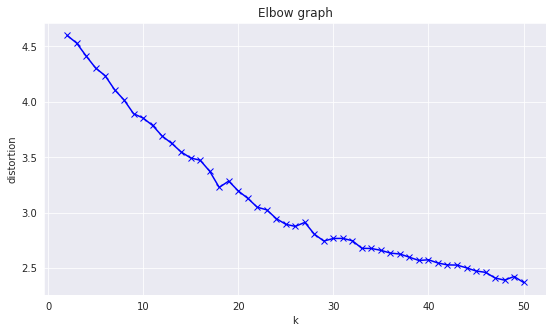

In [58]:
#eval_metrics=set(['ssd', 'msd']), mini_batch_size=15000, epochs=5
from scipy.spatial.distance import cdist
#plt.plot()
colors = ['b', 'g', 'r']
markers = ['o', 'v', 's']
models = {}
distortions = []
for k in K:
    s3_client = boto3.client('s3')
    key = 'kmeans_acloudguru/' + output_folder +'/'+ 'final-'+ str(k) + '/output/model.tar.gz'
    s3_client.download_file(bucket, key, 'model.tar.gz')
    print("Model for k={} ({})".format(k, key))
    !tar -xvf model.tar.gz                       
    kmeans_model=mx.ndarray.load('model_algo-1')
    kmeans_numpy = kmeans_model[0].asnumpy()
    distortions.append(sum(np.min(cdist(scaled, kmeans_numpy, 'euclidean'), axis=1)) / scaled.shape[0])
    models[k] = kmeans_numpy
 
# Plot the elbow
plt.figure(figsize=(9,5))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('distortion')
plt.title('Elbow graph')
plt.show()

## from above elbow plot, use k=28 

## run scikit-learn KMeans to compare with AWS SageMaker's KMean

start of fit for cluster 1
end of cluster: 1
with inertia: 1117872.0
start of fit for cluster 2
end of cluster: 2
with inertia: 1060382.138582437
start of fit for cluster 3
end of cluster: 3
with inertia: 1009459.682446636
start of fit for cluster 4
end of cluster: 4
with inertia: 965830.7917219724
start of fit for cluster 5
end of cluster: 5
with inertia: 924892.5171922654
start of fit for cluster 6
end of cluster: 6
with inertia: 884290.1572962988
start of fit for cluster 7
end of cluster: 7
with inertia: 844339.3039391666
start of fit for cluster 8
end of cluster: 8
with inertia: 811776.633606454
start of fit for cluster 9
end of cluster: 9
with inertia: 772477.0953218046
start of fit for cluster 10
end of cluster: 10
with inertia: 730837.0363272488
start of fit for cluster 11
end of cluster: 11
with inertia: 699619.1232943536
start of fit for cluster 12
end of cluster: 12
with inertia: 654691.0265985786
start of fit for cluster 13
end of cluster: 13
with inertia: 625729.9775728511


Text(0, 0.5, 'Inertia')

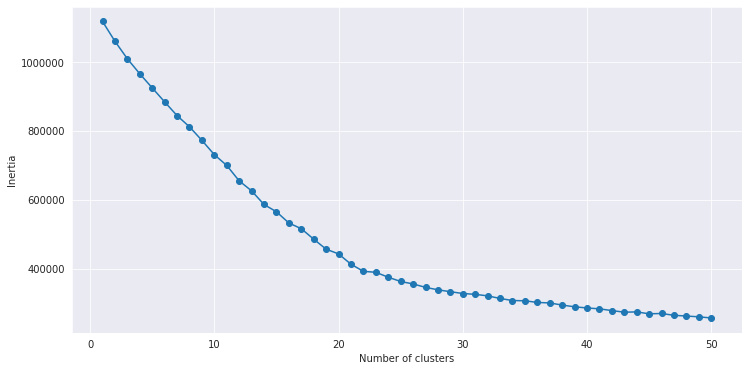

In [59]:
from sklearn.cluster import KMeans

# fitting multiple k-means algorithms and storing the values in an empty list
SSE = []
for cluster in range(1,51):
    print('start of fit for cluster', str(cluster))
    kmeans = KMeans(n_clusters = cluster, init='k-means++')
    kmeans.fit(scaled)
    SSE.append(kmeans.inertia_)
    print("end of cluster:", str(cluster))
    print("with inertia:", kmeans.inertia_)

# converting the results into a dataframe and plotting them
frame = pd.DataFrame({'Cluster':range(1,51), 'SSE':SSE})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

## from above elbow plot, k=25 is selected, something that is logical considering the number of genres (28)

## will continue to use Sagemaker's built-in KMeans algorithm in order to work with AWS services

In [63]:
#import again Sagemakers's KMean built-in algorithm
#must create the output S3 folder prior
#selected number of clusters k=28
from sagemaker import KMeans

kmeans = KMeans(role=role,
                instance_count=1,
                instance_type='ml.c4.xlarge',
                output_path='s3://'+ bucket + '/',
                init_method='kmeans++',
                k=28, 
                epochs=5)

In [64]:
#fit the KMeans model for k=28
kmeans.fit(kmeans.record_set(scaled.values))

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2020-12-30 18:18:33 Starting - Starting the training job...
2020-12-30 18:18:36 Starting - Launching requested ML instancesProfilerReport-1609352313: InProgress
......
2020-12-30 18:20:02 Starting - Preparing the instances for training......
2020-12-30 18:21:02 Downloading - Downloading input data...
2020-12-30 18:21:28 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
Running default environment configuration script
[12/30/2020 18:21:30 INFO 140024979371840] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001', u'local_lloyd_max_iter': u'300', u'_disable

## Deploy model - create endopoint 

In [65]:
kmeans_predictor = kmeans.deploy(initial_instance_count=1, instance_type='ml.t2.medium')

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


-------------------!

In [66]:
preds=kmeans_predictor.predict(scaled.values)


In [67]:
cluster_labels = [r.label['closest_cluster'].float32_tensor.values[0] for r in preds]

In [68]:
#number of movies in each cluster
pd.DataFrame(cluster_labels)[0].value_counts()

5.0     4671
19.0    3804
1.0     3342
24.0    2972
13.0    2598
4.0     2456
2.0     2246
22.0    1667
26.0    1590
18.0    1571
12.0    1388
3.0     1386
23.0    1328
25.0    1286
7.0     1257
11.0    1197
14.0    1172
27.0     977
8.0      850
15.0     763
17.0     687
0.0      438
20.0     217
10.0      49
6.0        9
21.0       2
16.0       1
Name: 0, dtype: int64

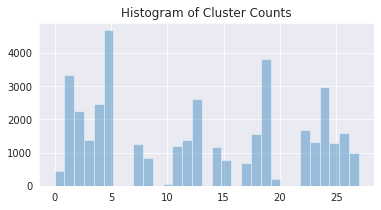

In [69]:
#plot the number of movies in each cluster
ax=plt.subplots(figsize=(6,3))
ax=sns.distplot(cluster_labels, kde=False)
title="Histogram of Cluster Counts"
ax.set_title(title, fontsize=12)
plt.show()

In [70]:
predictions = pd.DataFrame(data=cluster_labels)

In [71]:
pred_info = pd.concat([predictions, final], axis=1)

In [72]:
pred_info.head()

,0,startYear,runtimeMinutes,Mystery,Biography,Western,Documentary,Sci-Fi,Horror,Crime,...,Sport,Comedy,War,Drama,Animation,Action,Musical,Film-Noir,averageRating,numVotes
0,13.0,1999,102,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,7.4,1329
1,19.0,2009,92,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,6.3,1706
2,11.0,2014,110,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,6.8,1000
3,19.0,1945,129,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,8.0,7015
4,14.0,2002,115,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,6.2,13917


In [73]:
pred_info = pred_info.rename(columns={0: 'cluster'})

In [74]:
# fix dataframe with all data (movie titles, genre, numerical features, clusters)
pred_final = pd.concat([movie_data, pred_info], axis=1)                                                                       

In [75]:
pred_final.head()

,tconst,primaryTitle,originalTitle,cluster,startYear,runtimeMinutes,Mystery,Biography,Western,Documentary,...,Sport,Comedy,War,Drama,Animation,Action,Musical,Film-Noir,averageRating,numVotes
0,tt0000574,The Story of the Kelly Gang,The Story of the Kelly Gang,13.0,1999,102,0,0,0,0,...,0,1,0,1,0,0,0,0,7.4,1329
1,tt0002130,Dante's Inferno,L'Inferno,19.0,2009,92,0,0,0,0,...,0,0,0,1,0,0,0,0,6.3,1706
2,tt0002423,Passion,Madame DuBarry,11.0,2014,110,0,0,0,0,...,0,0,0,0,1,1,0,0,6.8,1000
3,tt0002844,Fantômas: In the Shadow of the Guillotine,Fantômas - À l'ombre de la guillotine,19.0,1945,129,0,0,0,0,...,0,0,0,1,0,0,0,0,8.0,7015
4,tt0003014,Ingeborg Holm,Ingeborg Holm,14.0,2002,115,0,0,0,0,...,0,0,1,1,0,0,0,0,6.2,13917


In [76]:
#sorted number of movies per cluster
pred_final.groupby('cluster')['tconst'].nunique()

cluster
0.0      438
1.0     3342
2.0     2246
3.0     1386
4.0     2456
5.0     4671
6.0        9
7.0     1257
8.0      850
10.0      49
11.0    1197
12.0    1388
13.0    2598
14.0    1172
15.0     763
16.0       1
17.0     687
18.0    1571
19.0    3804
20.0     217
21.0       2
22.0    1667
23.0    1328
24.0    2972
25.0    1286
26.0    1590
27.0     977
Name: tconst, dtype: int64

In [77]:
#Create data for a movie recommendation - year:1987, run time: 95 minutes, genres: thriller and film-noir

data = {'startYear':[1987], 'runtimeMinutes':[95], 'News':[0], 'Animation':[0], 'Horror':[0], 'History':[0],
       'Thriller':[1], 'Biography':[0], 'Mystery':[0], 'Short':[0], 'Sci-Fi':[0], 'Comedy':[0],
       'Music':[0], 'Western':[0], 'Musical':[0], 'Crime':[0], 'Family':[0], 'Romance':[0],
       'Documentary':[0], 'Fantasy':[0], 'Adventure':[0], 'Film-Noir':[1], 'Drama':[0], 'Action':[0],
       'Sport':[0], 'War':[0], 'averageRating':[6.7], 'numVotes':[3700]}

in_data1 = pd.DataFrame(data)
input1 = scaler.transform(in_data1).astype('float32')

## Get prediction from deployed inference endpoint

In [78]:
input1_pred = kmeans_predictor.predict(input1)
input1_cluster = [r.label['closest_cluster'].float32_tensor.values[0] for r in input1_pred]

In [79]:
#predicted cluster
print(int(input1_cluster[0]))

12


## Get 15 recommendations from predicted cluster, ordered by average rating and number of votes

In [80]:
recommendations = pred_final.loc[pred_final['cluster'] == int(input1_cluster[0])].sort_values(by =['averageRating', 'numVotes'], ascending=False)[:15]
recommendations

,tconst,primaryTitle,originalTitle,cluster,startYear,runtimeMinutes,Mystery,Biography,Western,Documentary,...,Sport,Comedy,War,Drama,Animation,Action,Musical,Film-Noir,averageRating,numVotes
33565,tt3624628,Soft Lad,Soft Lad,12.0,2011,130,0,0,0,0,...,0,0,0,1,0,0,0,0,8.7,3127
39603,tt9076562,Irresistible,Irresistible,12.0,1973,93,0,0,0,0,...,0,1,0,0,0,0,0,0,8.4,14828
30409,tt2196053,Something Like Summer,Something Like Summer,12.0,1927,153,0,0,0,0,...,0,0,0,1,0,0,0,0,8.3,158018
4174,tt0052631,The Black Orchid,The Black Orchid,12.0,2013,135,0,0,0,0,...,0,0,0,1,0,0,0,0,8.3,11399
23040,tt0823240,The Romance of Astrea and Celadon,Les amours d'Astrée et de Céladon,12.0,1979,162,0,0,0,0,...,0,0,0,1,0,0,0,0,8.2,114309
12097,tt0102313,The Linguini Incident,The Linguini Incident,12.0,1982,109,1,0,0,0,...,0,0,0,0,0,0,0,0,8.1,366136
34291,tt4071086,Wild,Wild,12.0,1972,167,1,0,0,0,...,0,0,0,1,0,0,0,0,8.1,79500
35308,tt4802214,Chihayafuru Part II,Chihayafuru Part II,12.0,1986,135,0,0,0,0,...,0,1,0,1,0,0,0,0,8.1,11317
12491,tt0105032,Savage Nights,Les nuits fauves,12.0,1968,112,0,0,0,0,...,0,0,0,0,0,0,0,0,8.0,163963
36353,tt5565670,Ardaas,Ardaas,12.0,2004,127,0,0,0,0,...,0,1,0,0,0,0,0,0,8.0,55850


## one more example

In [94]:
#Create data for a movie recommendation

data = {'startYear':[2010], 'runtimeMinutes':[150], 'News':[0], 'Animation':[0], 'Horror':[0], 'History':[0],
       'Thriller':[0], 'Biography':[0], 'Mystery':[0], 'Short':[0], 'Sci-Fi':[0], 'Comedy':[0],
       'Music':[0], 'Western':[0], 'Musical':[0], 'Crime':[0], 'Family':[0], 'Romance':[0],
       'Documentary':[0], 'Fantasy':[0], 'Adventure':[0], 'Film-Noir':[0], 'Drama':[1], 'Action':[0],
       'Sport':[0], 'War':[0], 'averageRating':[5.3], 'numVotes':[8000]}

in_data2 = pd.DataFrame(data)
input2 = scaler.transform(in_data2).astype('float32')

In [95]:
input2_pred = kmeans_predictor.predict(input2)
input2_cluster = [r.label['closest_cluster'].float32_tensor.values[0] for r in input2_pred]

In [96]:
#predicted cluster
print(int(input2_cluster[0]))

11


In [97]:
recommendations = pred_final.loc[pred_final['cluster'] == int(input2_cluster[0])].sort_values(by =['averageRating', 'numVotes'], ascending=False)[:15]
recommendations

,tconst,primaryTitle,originalTitle,cluster,startYear,runtimeMinutes,Mystery,Biography,Western,Documentary,...,Sport,Comedy,War,Drama,Animation,Action,Musical,Film-Noir,averageRating,numVotes
15185,tt0135625,The Republic of ShKID,Respublika ShKID,11.0,2020,95,0,0,0,1,...,0,0,0,0,1,0,0,0,9.1,595
3814,tt0050367,The Spies,Les espions,11.0,1992,170,0,0,0,0,...,0,0,0,0,1,1,0,0,9.0,2024
2275,tt0039645,My Favorite Brunette,My Favorite Brunette,11.0,2018,104,0,0,0,0,...,0,0,0,0,1,0,0,0,8.9,661
15059,tt0129023,Dark Harbor,Dark Harbor,11.0,2015,47,0,0,0,0,...,0,0,0,0,1,0,0,0,8.7,770
9757,tt0086872,Prey,Prey,11.0,2019,97,0,0,0,0,...,0,0,0,0,1,1,0,0,8.7,756
205,tt0016230,The Pleasure Garden,The Pleasure Garden,11.0,2016,134,0,0,0,0,...,0,0,0,0,1,0,0,0,8.6,588
20841,tt0421539,9/Tenths,9/Tenths,11.0,1975,88,0,0,0,0,...,0,1,0,0,1,0,0,0,8.5,12332
4969,tt0057426,The Prize,The Prize,11.0,2020,117,0,0,0,0,...,0,0,0,0,1,1,0,0,8.5,1556
21371,tt0446320,The End of Suburbia: Oil Depletion and the Col...,The End of Suburbia: Oil Depletion and the Col...,11.0,1989,59,0,0,0,0,...,0,1,0,0,1,0,0,0,8.5,986
39782,tt9507234,Digimon Adventure: Last Evolution Kizuna,Digimon Adventure: Last Evolution Kizuna,11.0,1986,48,0,0,0,0,...,0,1,0,0,1,0,0,0,8.5,839


## Above we see the effect of the criteria of keeping data with 500  votes and above. 

In [98]:
#Because endpoints are persistent, delete the endpoint to stop incurring costs
import sagemaker

sagemaker.Session().delete_endpoint(kmeans_predictor.endpoint_name)


In [99]:
print('end time:', datetime.datetime.now())

end time: 2020-12-30 18:40:21.976540
